In [2]:
# plot all maps 

In [3]:
from surfplot import Plot
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
from utils import get_annot_labels
from utils import rois2maps
from neuromaps.datasets import fetch_fsaverage

In [22]:
base = os.path.dirname(os.getcwd())

flu = pd.read_csv(base + '/data/Flupentixol/Flupentixol_parcelwise.csv')
ami = pd.read_csv(base + '/data/Amisulpride/Amisulpride_parcelwise.csv')
ris = pd.read_csv(base + '/data/Risperidone/Risperidone_parcelwise.csv')
clo = pd.read_csv(base + '/data/Clozapine/Clozapine_parcelwise.csv')
ola = pd.read_csv(base + '/data/Olanzapine/Olanzapine_parcelwise.csv')

In [26]:
lh_labels = get_annot_labels('lh.aparc.annot')    
rh_labels = get_annot_labels('rh.aparc.annot')

In [24]:
def plot_thickness(dat):
    lh_dat = dat.loc[dat['parcel'].str.contains('lh_'),:]
    lh_dat.loc[:,'hedges_g'] = lh_dat['hedges_g'] + 0.001 # weird 
    rh_dat = dat.loc[dat['parcel'].str.contains('rh_'),:]
    pmap = rois2maps(lh_dat, rh_dat, 'hedges_g', lh_labels, rh_labels)
    
    surface = fetch_fsaverage(density='164k')
    lh, rh = surface['inflated']
    dk = {'left': np.array(lh_labels), 'right': np.array(rh_labels)} # outlines 
    
    p = Plot(lh, rh, views=['lateral', 'medial'], zoom=1.2)
    p.add_layer(pmap, cmap='Blues_r', cbar_label='')
    p.add_layer(dk, as_outline=True, cbar=False)
      
    pic = p.build()
    
    # fix legend 
    cbar_ax = pic.axes[-1]
    cbar_ax.set_ylabel('')
    cbar_ax.set_title("Hedges' g", pad=10);
    #plt.title('Olanzapine');
    
    #pic.savefig(os.path.join(base_path + '/figs/Olanzapine_parcelwise_hedges_g.jpg'), dpi=300, transparent=True)



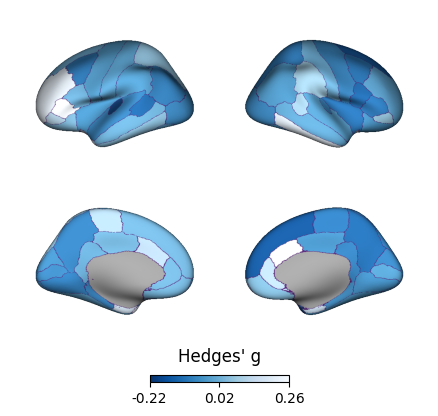

In [29]:
plot_thickness(ami)

In [ ]:
# plotting.py  (or any module you like)

from __future__ import annotations
import os
from pathlib import Path
from typing import Sequence, Tuple, Optional

import numpy as np
import pandas as pd
from nilearn.datasets import fetch_fsaverage
from surfplot import Plot                           # ← or your own wrapper

# --------------------------------------------------------------------- #
# ── helpers ─────────────────────────────────────────────────────────── #
# --------------------------------------------------------------------- #

def _split_hemispheres(df: pd.DataFrame,
                       value_col: str = "hedges_g"
                       ) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Return left- and right-hemisphere rows as *copies* (safe to mutate)."""
    lh = df[df["parcel"].str.contains("lh_")].copy()
    rh = df[df["parcel"].str.contains("rh_")].copy()

    # small numeric offset so the two maps don't overlap when values hit zero
    lh[value_col] += 1e-3
    return lh, rh


def _make_pmap(lh: pd.DataFrame,
               rh: pd.DataFrame,
               value_col: str,
               lh_labels: Sequence[int],
               rh_labels: Sequence[int]):
    """Convert parcel values → vertex map (your existing rois2maps logic)."""
    return rois2maps(lh, rh, value_col, lh_labels, rh_labels)


def _get_fsaverage(density: str = "164k"):
    """Fetch the fsaverage surfaces only once (caches in ~/.nilearn)."""
    surf = fetch_fsaverage(density=density)
    return surf["inflated"]          # (lh_surf, rh_surf)


# --------------------------------------------------------------------- #
# ── main API ────────────────────────────────────────────────────────── #
# --------------------------------------------------------------------- #

def plot_thickness(
    df: pd.DataFrame,
    *,
    lh_labels: Sequence[int],
    rh_labels: Sequence[int],
    value_col: str = "hedges_g",
    cmap: str = "Blues_r",
    vmin: Optional[float] = None,
    vmax: Optional[float] = None,
    views: Sequence[str] = ("lateral", "medial"),
    zoom: float = 1.2,
    outfile: Optional[os.PathLike] = None,
) -> "surfplot.Figure":
    """
    Plot parcel-wise effect sizes on an fsaverage surface.

    Parameters
    ----------
    df : DataFrame
        Must contain 'parcel' and *value_col* columns.
    lh_labels, rh_labels : sequence
        Numeric parcel indices for each hemisphere (used by `rois2maps`).
    value_col : str, default 'hedges_g'
        Column holding the metric to visualise.
    cmap : str
        Matplotlib colormap name (default 'Blues_r').
    vmin, vmax : float or None
        Colourbar limits.  None = let surfplot choose.
    views : sequence of str
        E.g. ('lateral', 'medial', 'dorsal').
    zoom : float
        Passed to `surfplot.Plot`.
    outfile : path or None
        If given, save the figure here (extension decides format).

    Returns
    -------
    fig : surfplot.Figure
        The built figure (so caller can `.show()` or tweak further).
    """
    # ---------------- data ----------------
    lh, rh = _split_hemispheres(df, value_col)
    pmap = _make_pmap(lh, rh, value_col, lh_labels, rh_labels)

    # ---------------- surfaces ------------ 
    lh_surf, rh_surf = _get_fsaverage()

    # ---------------- plotting ------------
    plt_obj = Plot(lh_surf, rh_surf, views=views, zoom=zoom)
    plt_obj.add_layer(pmap, cmap=cmap, vmin=vmin, vmax=vmax, cbar_label="")
    plt_obj.add_layer(
        {"left": np.asarray(lh_labels),
         "right": np.asarray(rh_labels)},
        as_outline=True, cbar=False
    )
    fig = plt_obj.build()

    # tidy colour-bar
    cbar_ax = fig.axes[-1]
    cbar_ax.set_ylabel("")
    cbar_ax.set_title("Hedges' g", pad=10)

    # optional file-save
    if outfile is not None:
        outfile = Path(outfile)
        outfile.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(outfile, dpi=300, transparent=True)

    return fig
